In [1]:
# import libraries 
from pathlib import Path
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

sns.set_theme()

plt.rcParams['figure.figsize'] = [10, 8]

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
###################################

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import FluoSpecModel from fluospec package's module model
# FluoSpecModel is a class containing generative model and eventual helper methods
from fluospec.model import FluoSpecModel, Prediction, SimulateFluoSpec
# import data loading helper
from fluospec.data_io import load_data

# 2. Generative model:
For atomic and molecular lineshape models, theory describes that in the absence of external broadening mechanisms,  the intensity profile of the fluorescence of atoms and molecules is given by a Lorentzian line shape:
$$ I(f) = A \frac{\Gamma^2/4}{(f - f_0)^2 + \Gamma^2/4}$$
where $A$ is the amplitude, $f_0$ is the center frequency of the fluorescence and $\Gamma$ is the decay rate of the transition (also the full width at half maximum). We assume that any broadening we later add is a function of the linewidth, Doppler broadening, plus any additional width imparted by the camera. 

In our data, we have a background that is linear with the frequency which can be modeled by a linear equation as given below. This drift can be explained as a frequency dependent intensity shift which the camera experiences, such that the camera is more sensitive to increasing frequency.

$$ I_b(f) = mf + b$$
such that the full model is 
$$I_T(f) = I(f) + I_b(f) = A \frac{\Gamma^2/4}{(f - f_0)^2 + \Gamma^2/4} + (mf + b)$$

Noise on the camera is fairly complex, but data points are averaged, so that the noise on the camera can be characterized as Gaussian with $\sigma$ = 0.2, thus:
$$ y_i \sim \text{normal}(\mu_i = I_T(f_i) ,\sigma_i = 0.2)$$

In addition to the lineshape model, we can add a parameter that accounts for the power broadening of the lineshape: 

$$I_T(f) = I(f) + I_b(f) = A \frac{\Gamma^2/4}{(f - f_0)^2 + \Gamma^2/4\left(1+\frac{I}{I_{\text{sat}}}\right)} + (mf + b)$$

Lastly we will use gamma (for positive parameters) and normal priors since our bounds aren't well defined:

$$A \sim \text{gamma}(\mu = 0.2,\sigma = 0.1)$$

$$f_0 \sim \text{gamma}(\mu = 290, \sigma = 10)$$

$$\Gamma \sim \text{gamma}(\mu = 0.5,\sigma = 0.1)$$

$$ \frac{I}{I_{\text{sat}}} \sim \text{gamma}(\mu = 0.5,\sigma = 0.1)$$

$$m \sim \text{normal}(\mu = 0.05,\sigma = 0.01)$$

$$b \sim \text{normal}(\mu = 1,\sigma = 0.2)$$

Thus the full statistical model is:
$$ y_i \sim \text{normal}(\mu_i = I_T(f_i) ,\sigma_i = 0.2)\\A \sim \text{gamma}(5,1) \\f_0 \sim \text{gamma}(20,4)\\\Gamma \sim \text{gamma}(5,1)\\\frac{I}{I_{\text{sat}}} \sim \text{gamma}(0.5, 0.1)\\m \sim \text{normal}(0.05,0.1)\\b \sim \text{normal}(2,0.4)$$


# 3. Simulation of data:
We begin by loading our simulated data, generated with the means of the priors above with added Gaussian noise. 

In [17]:
# load simulated data from pickle or csv
sim_data = load_data(Path('./fluospec/sim_data/fluospec_sim_data.pkl'))

sim_data = SimulateFluoSpec.init_with_defaults().generate_sim_data()

# define some more data vectors for convenience
sim_w = sim_data.w
sim_I = sim_data.I
sim_sigma_I = sim_data.sigma_I

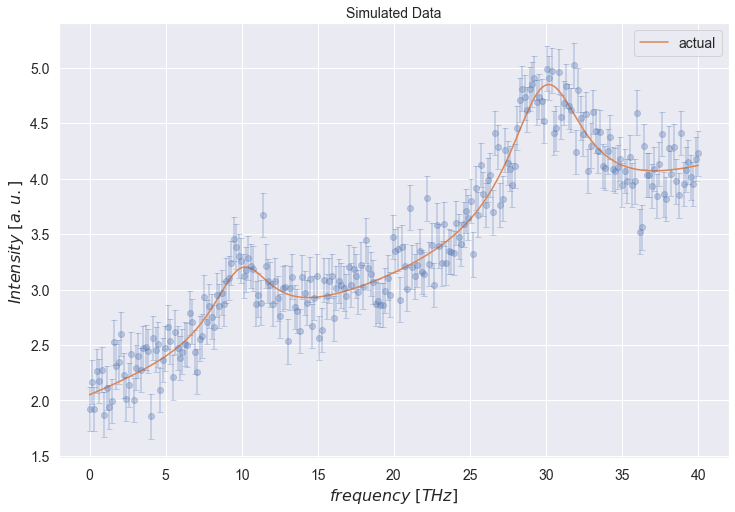

In [18]:
plt.figure(figsize=(12,8))
plt.errorbar(sim_w, sim_I, yerr=sim_sigma_I, fmt='o', capsize=3, alpha=.3)
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('Simulated Data');

w_inf = np.linspace(sim_data.w.min(), sim_data.w.max(), 250)

prediction_w_actual = Prediction.init_with_defaults().prediction(w_inf)

plt.plot(w_inf, prediction_w_actual, label='actual')
plt.legend();

# How to use `fluospec`

To use the main class of `fluospec`, `FluoSpecModel`, we first instantiate it. Internally, `FluoSpecModel` implements the priors as given above. In order to instantiate the class, one initializes `FluoSpecModel` with a list of tuples of `(mean, std)` for every prior of a spectal line (thus elements of the list are the prior parameters for an individual spectral line). The spectrograph drift is modeled by a linear drift. The parameters for this background can be passed with parameters `m_prior_params` and `b_prior_params`, which are tuples of the `(<mean>, <std>)` for a normal prior. Use `FluoSpecModel?` for the exact ordering or the names of the arguments. Alternatively, define a dictionary with keys `<PARAMETER>_prior_params` and their respective data structure, and use dictionary expansion to instantiate `FluoSpecModel`. After instantiation, one can change these parameters using `<INSTANCE_NAME>.<PARAMETER>_prior_params`.

Next, we call the `model` method, with a pandas DataFrame of the data as a parameter. This method will return a pymc3 Model that we can then use for inference. `model` expects the data as loaded by `load_data` (*ie* with the `w`, `I`, and `sigma_I` columns).

In [19]:
model_prior_params = {
                      'line_prior_params': [
                                          ((2, 1), (30, 2), (5, 1), (.5, .1)),
                                          ((1, 1), (10, 2), (4, .5), (.5, .1))
                                           ],
                      'm_prior_params': (.0, .01),
                      'b_prior_params': (2, .04),
                      }

fluospec_model_instance = FluoSpecModel(**model_prior_params)

# print what the mean and std on the m parameter are
print(f"mean, std of m parameter: {fluospec_model_instance.m_prior_params}")

# Let's change it to (.05, .01)
fluospec_model_instance.m_prior_params = (.05, .01)
print(f"mean, std of m parameter after changing: {fluospec_model_instance.m_prior_params}")

mean, std of m parameter: (0.0, 0.01)
mean, std of m parameter after changing: (0.05, 0.01)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, intensity_ratio_1, gamma_1, w0_1, A_1, intensity_ratio_0, gamma_0, w0_0, A_0]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 26 seconds.


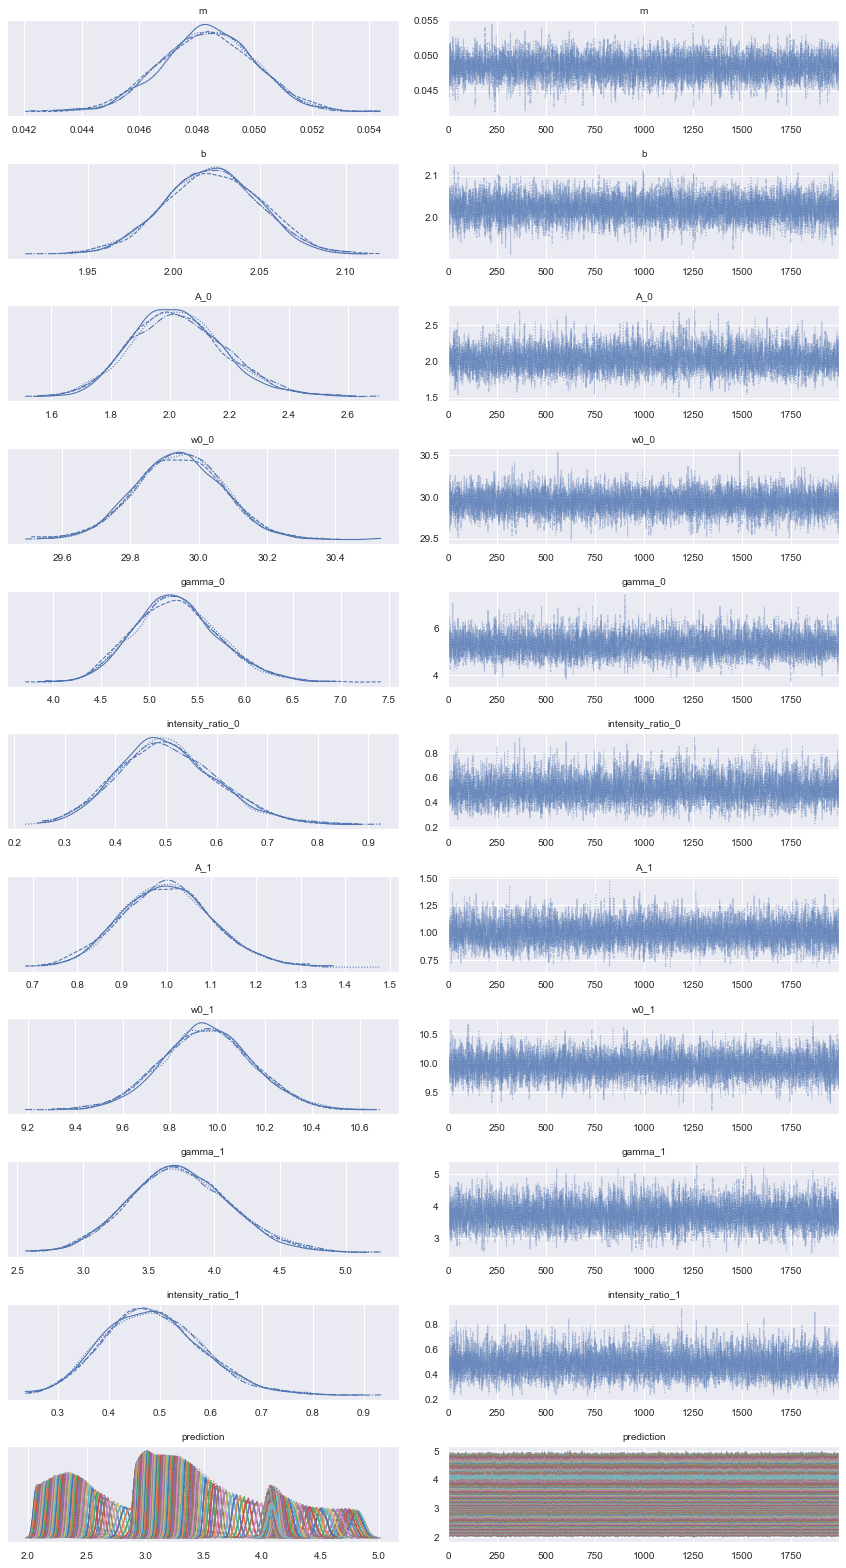

In [20]:
generative_model = fluospec_model_instance.model(sim_data)

with generative_model:
    trace = pm.sample(return_inferencedata=True, tune=5000, draws=2000)
    az.plot_trace(trace)
    plt.tight_layout()
    
posterior = trace.posterior.to_dataframe()

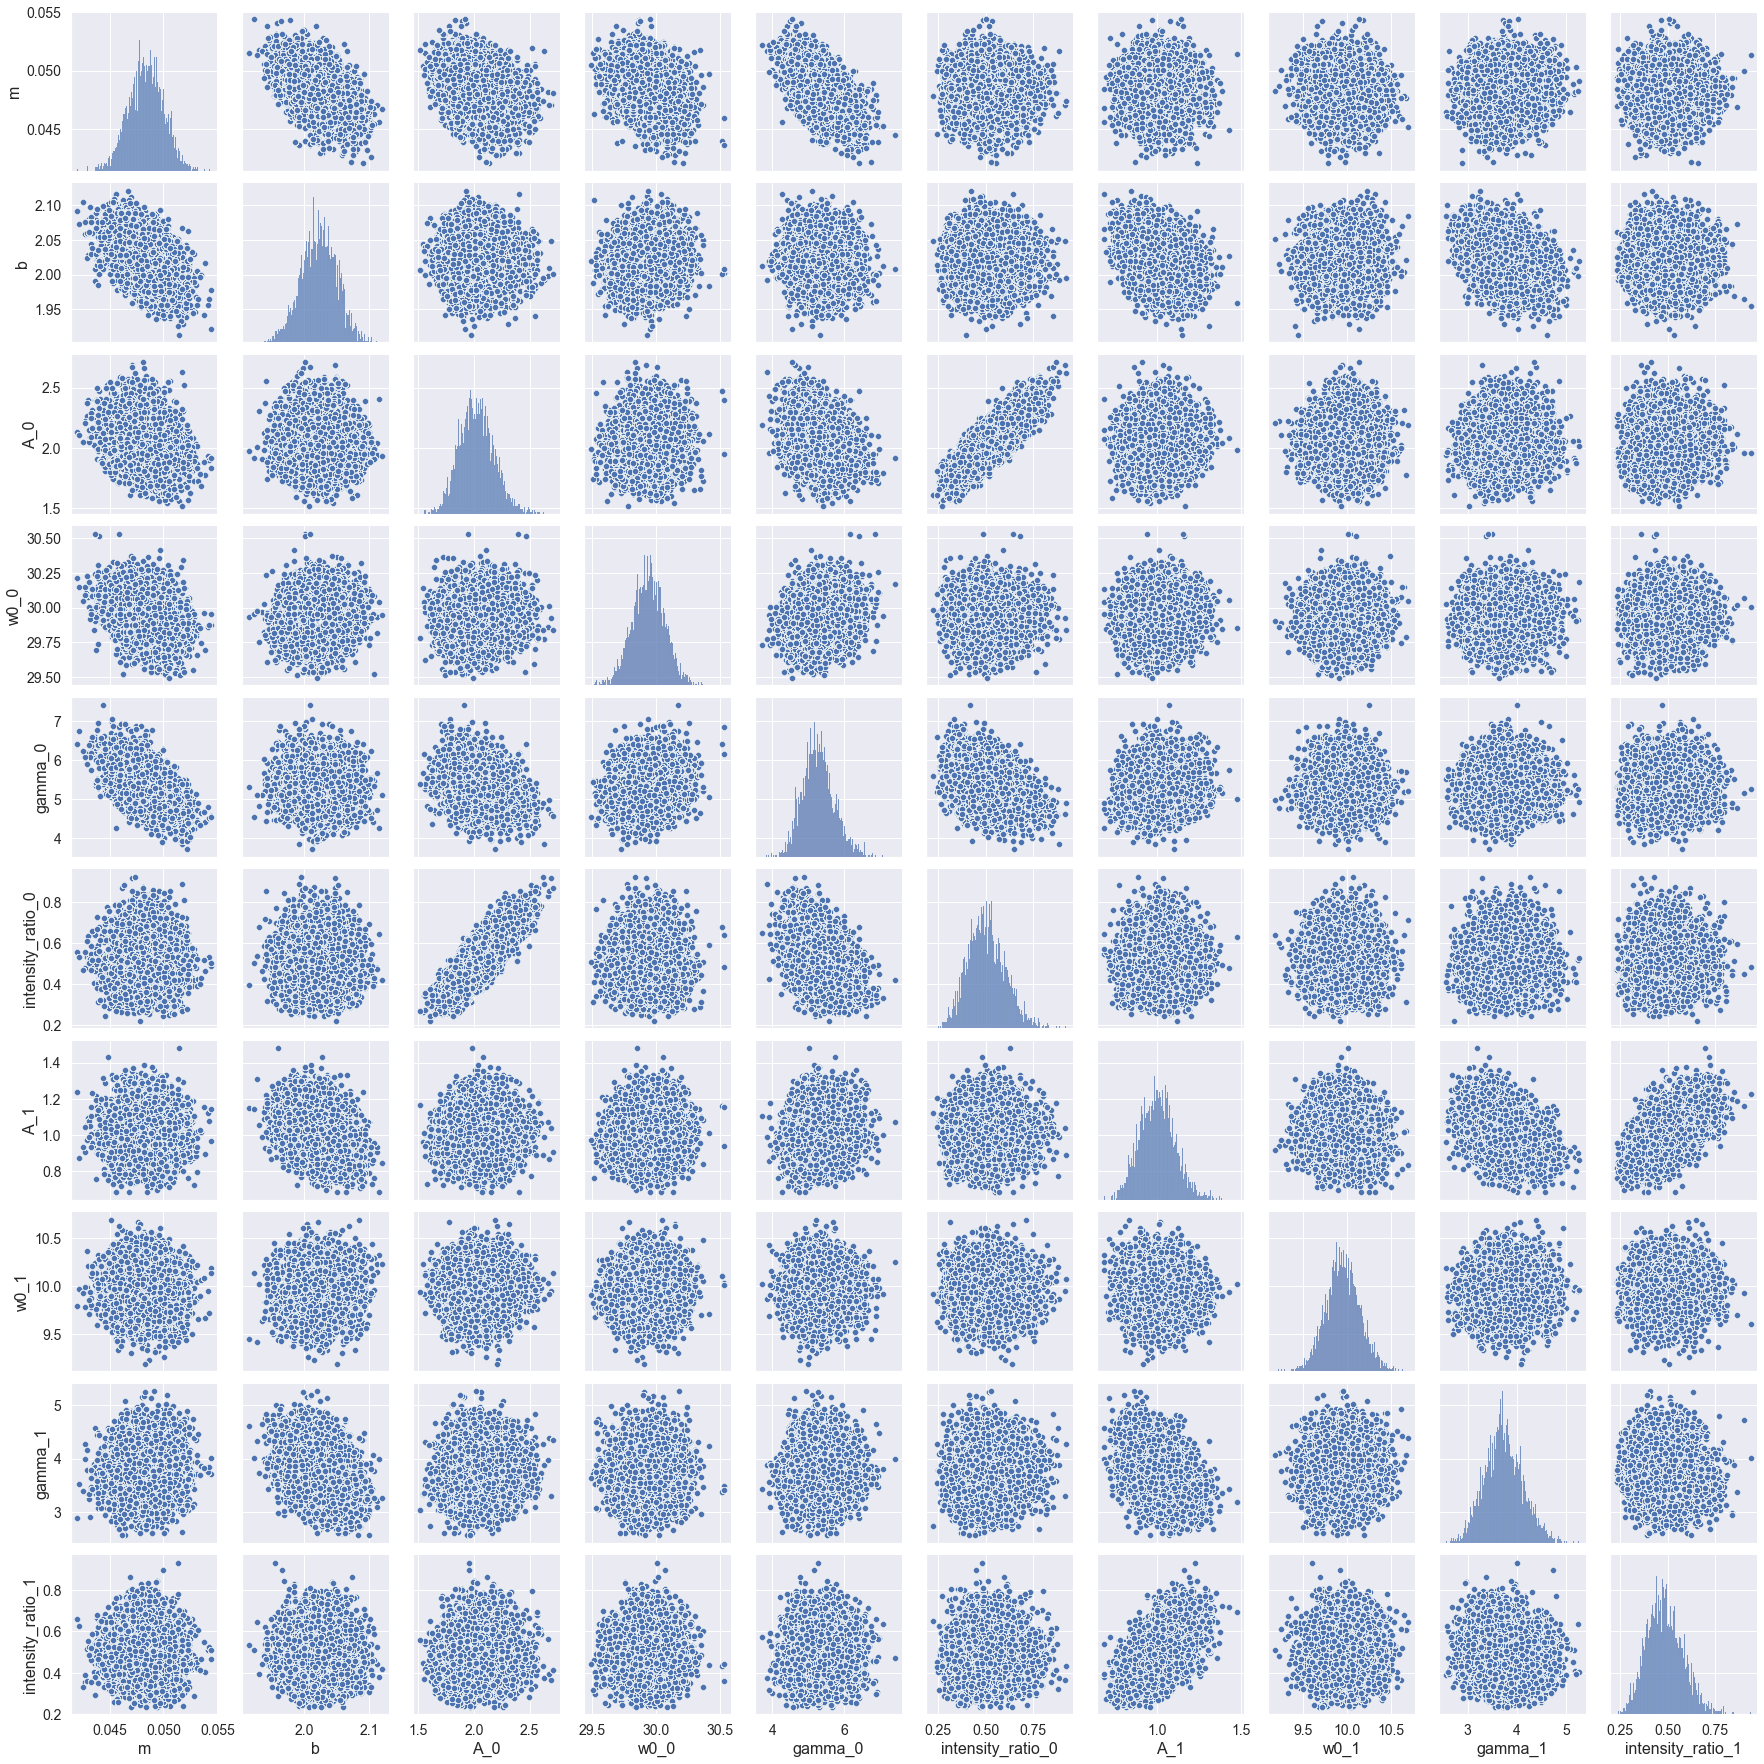

In [23]:
sns.pairplot(posterior.drop('prediction', axis=1))

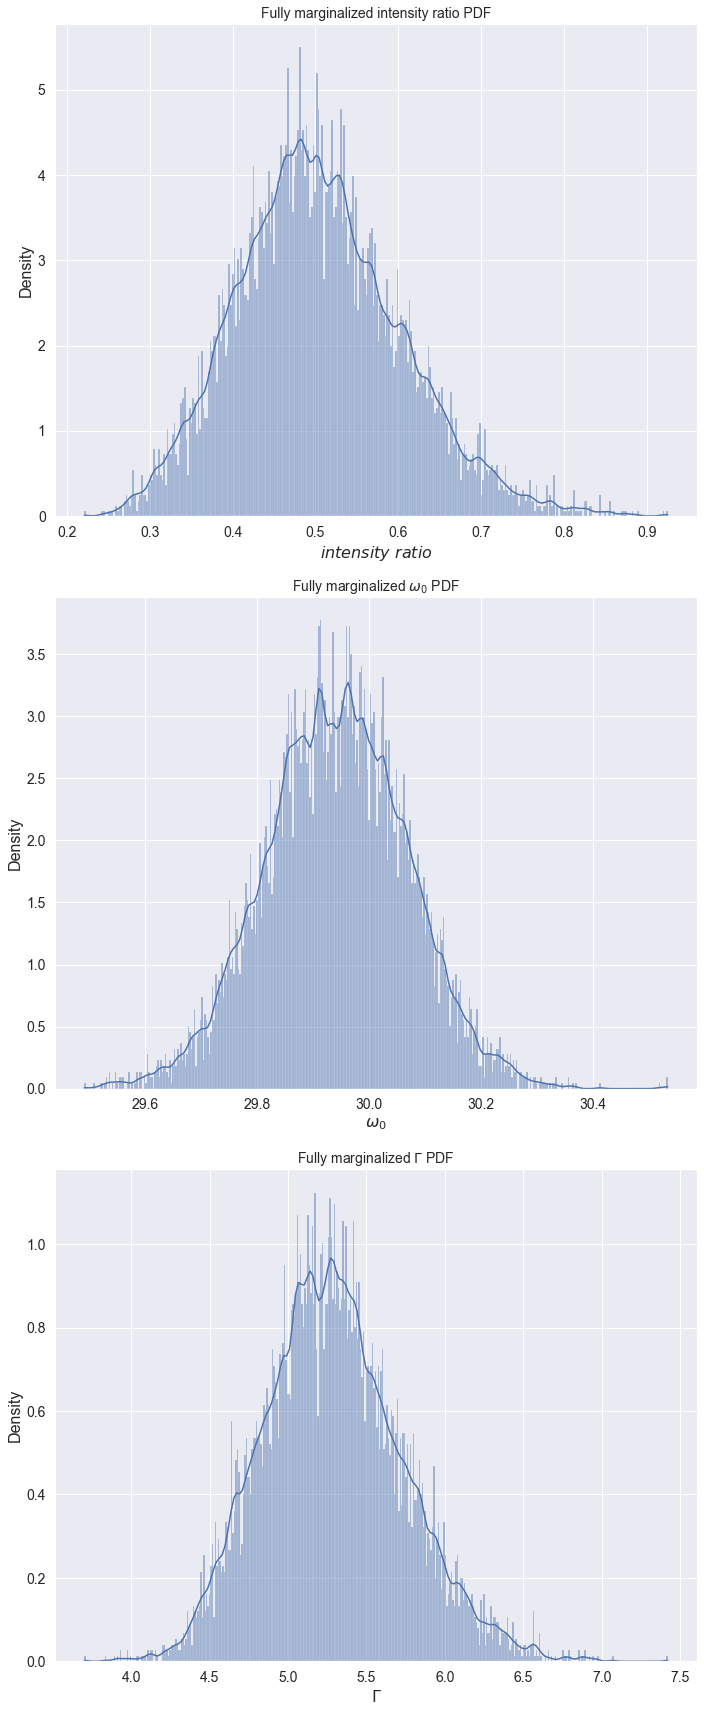

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 24))

marg_intensity_ratio = sns.histplot(posterior.intensity_ratio_0,
                                    fill=True, stat="density",
                                    kde=True,
                                    ax=ax1
                                    )
marg_intensity_ratio.set(xlabel='$intensity \ ratio$',
                         title='Fully marginalized intensity ratio PDF'
                         );


marg_w0 = sns.histplot(posterior.w0_0,
                       fill=True, stat="density",
                       kde=True,
                       ax=ax2
                      )
marg_w0.set(xlabel='$\omega_0$',
            title='Fully marginalized $\omega_0$ PDF'
            );

marg_gamma = sns.histplot(posterior.gamma_0,
                          fill=True, stat="density",
                          kde=True,
                          ax=ax3
                         )
marg_gamma.set(xlabel='$\Gamma$',
               title='Fully marginalized $\Gamma$ PDF'
               );

plt.tight_layout()

In [25]:
summary = az.summary(trace, hdi_prob=.95)[0:11]
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.048,0.002,0.045,0.052,0.000,0.000,6908.0,5118.0,1.0
b,2.022,0.028,1.969,2.076,0.000,0.000,7642.0,5894.0,1.0
A_0,2.028,0.160,1.719,2.342,0.002,0.001,6077.0,4778.0,1.0
w0_0,29.942,0.128,29.696,30.194,0.001,0.001,8592.0,6283.0,1.0
gamma_0,5.288,0.447,4.432,6.163,0.005,0.004,6984.0,5533.0,1.0
intensity_ratio_0,0.505,0.099,0.318,0.707,0.001,0.001,5938.0,5305.0,1.0
A_1,1.003,0.104,0.792,1.202,0.001,0.001,7414.0,6302.0,1.0
w0_1,9.956,0.193,9.580,10.332,0.002,0.001,9032.0,5172.0,1.0
gamma_1,3.737,0.388,2.954,4.479,0.004,0.003,7895.0,5435.0,1.0
intensity_ratio_1,0.486,0.096,0.305,0.675,0.001,0.001,7569.0,5646.0,1.0


## Comparison
Let's see how our inference did by comparing the real curve to the one from the inferred parameters.

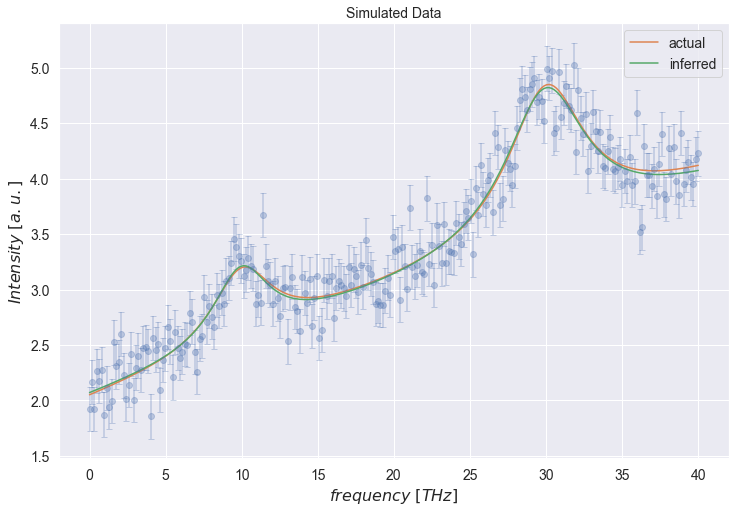

In [26]:
plt.figure(figsize=(12,8))
plt.errorbar(sim_w, sim_I, yerr=sim_sigma_I, fmt='o', capsize=3, alpha=.3)
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('Simulated Data');

A_inf = summary['mean']['A_0']
w0_inf = summary['mean']['w0_0']
gamma_inf = summary['mean']['gamma_0']
intensity_ratio_inf = summary['mean']['intensity_ratio_0']

A_inf0 = summary['mean']['A_1']
w0_inf0 = summary['mean']['w0_1']
gamma_inf0 = summary['mean']['gamma_1']
intensity_ratio_inf0 = summary['mean']['intensity_ratio_1']

m_inf = summary['mean']['m']
b_inf = summary['mean']['b']

w_inf = np.linspace(sim_data.w.min(), sim_data.w.max(), 250)

prediction_w_actual = Prediction.init_with_defaults().prediction(w_inf)

prediction_inferred = Prediction([
                                 (A_inf, w0_inf, gamma_inf, intensity_ratio_inf),
                                 (A_inf0, w0_inf0, gamma_inf0, intensity_ratio_inf0)
                                  ],
                                 m_inf,
                                 b_inf
                        ).prediction(w_inf)

plt.plot(w_inf, prediction_w_actual, label='actual')
plt.plot(w_inf, prediction_inferred, label='inferred')
plt.legend();

# Real Data
Let's run the above sequence on real data.

In [27]:
# load simulated data from pickle or csv
real_data = load_data(Path('./fluospec/real_data/fluorescence_spectroscopy.csv'))

# define some more data vectors for convenience
w = real_data.w
I = real_data.I
real_data.sigma_I = .01
sigma_I = real_data.sigma_I
real_data.head()

,w,I,sigma_I
0,288.306712,-0.555336,0.01
1,288.312582,-0.551050,0.01
2,288.318451,-0.554088,0.01
3,288.324321,-0.541078,0.01
4,288.330190,-0.533921,0.01


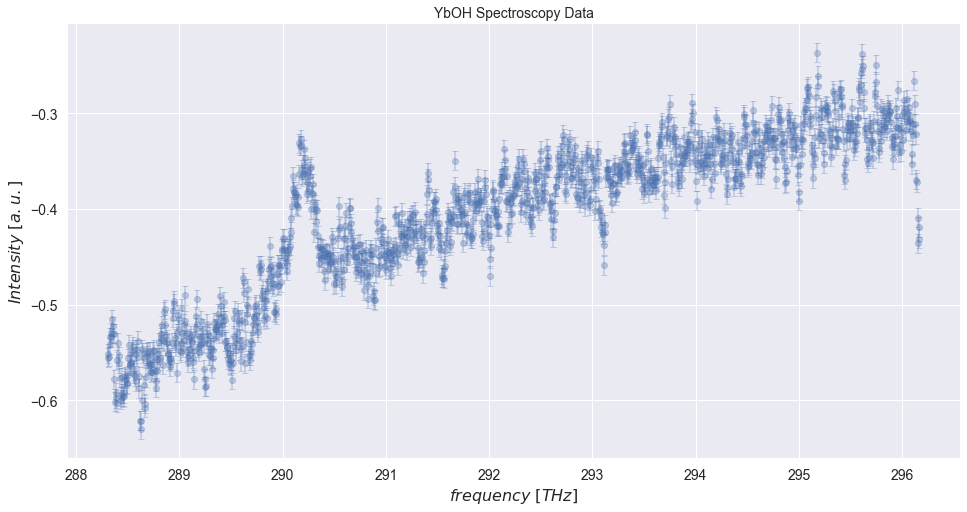

In [28]:
plt.figure(figsize=(16, 8))
plt.errorbar(w, I, fmt='o', yerr=sigma_I, capsize=3, alpha=.3)
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('YbOH Spectroscopy Data');

In [29]:
model_prior_params = {
                      'line_prior_params': [(
                                            (0.2, 0.1),
                                            (290.2, 1),
                                            (0.5, 0.1),
                                            (.1, .1),
                                            )
                                            ],
                      'm_prior_params': (0.05, .1),
                      'b_prior_params': (-14.7, .1),
                      }

fluospec_model_instance = FluoSpecModel(**model_prior_params)

# Modeling noise as Gaussian

Initially we modeled the noise as Guassian, but this led to failures during inference. As a first pass through, we cut off data that's not near our interesting peak. We then use a [sequential Monte Carlo sampler](https://docs.pymc.io/en/v3/pymc-examples/examples/samplers/SMC2_gaussians.html) to explore the posterior. Note that the posterior is highly multimodal, indicating the presence of additional structure in our data. 

Initializing SMC sampler...
Sampling 10 chains in 10 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.003
Stage:   7 Beta: 0.006
Stage:   8 Beta: 0.011
Stage:   9 Beta: 0.019
Stage:  10 Beta: 0.048
Stage:  11 Beta: 0.075
Stage:  12 Beta: 0.100
Stage:  13 Beta: 0.142
Stage:  14 Beta: 0.243
Stage:  15 Beta: 0.336
Stage:  16 Beta: 0.583
Stage:  17 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.003
Stage:   7 Beta: 0.007
Stage:   8 Beta: 0.014
Stage:   9 Beta: 0.023
Stage:  10 Beta: 0.033
Stage:  11 Beta: 0.082
Stage:  12 Beta: 0.146
Stage:  13 Beta: 0.199
Stage:  14 Beta: 0.262
Stage:  15 Beta: 0.470
Stage:  16 Beta: 0.635
Stage:  17 Beta: 0.791
Stage:  18 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000

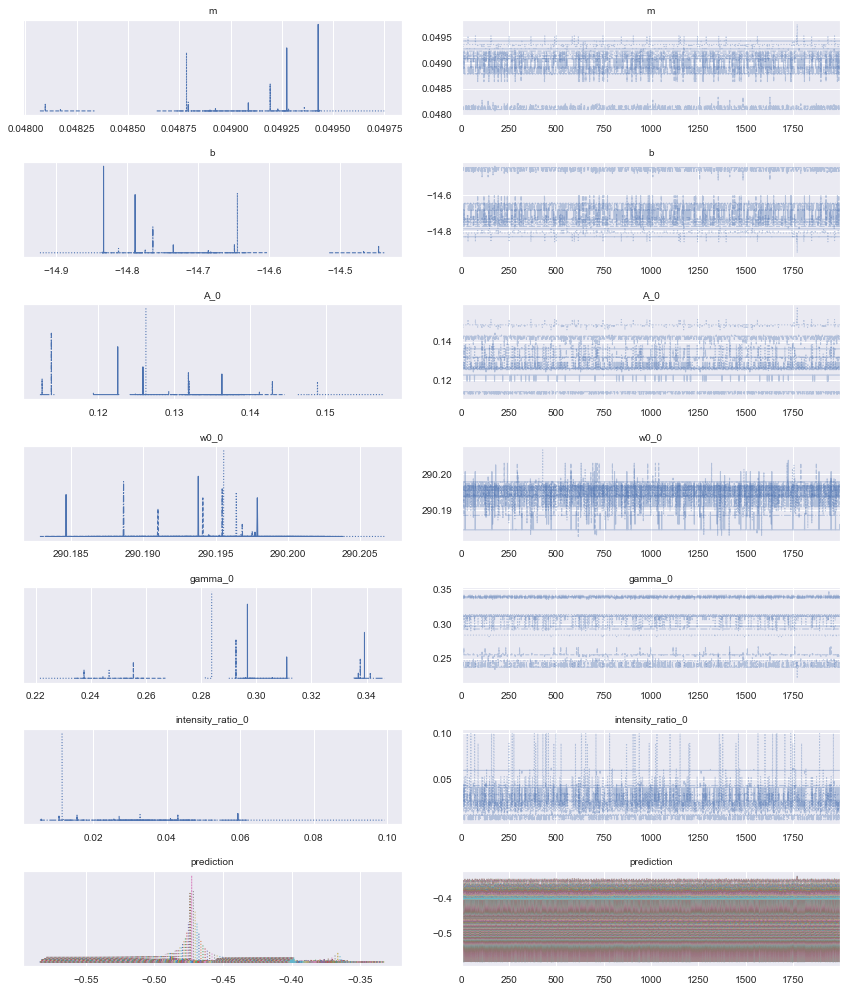

In [30]:
real_data_cut = real_data[real_data.w < 292].reset_index(drop=True)
generative_model = fluospec_model_instance.model(real_data_cut, likelihood='normal')

with generative_model:
    trace_normal = pm.sample_smc(2000)
    az.plot_trace(trace_normal)
    plt.tight_layout()

Got error No model on context stack. trying to find log_likelihood in translation.
C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


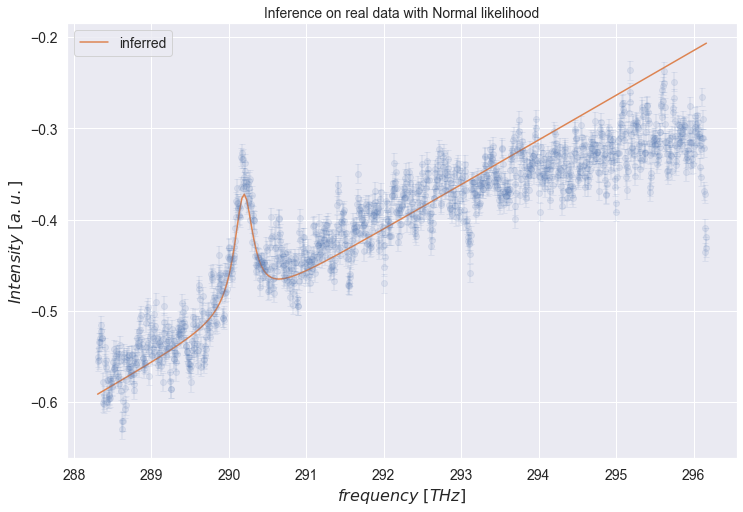

In [31]:
summary_normal = az.summary(trace_normal, hdi_prob=.95)[0:6]

plt.figure(figsize=(12,8))
plt.errorbar(w, I, fmt='o', yerr=sigma_I, capsize=3, alpha=.1)
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('Inference on real data with Normal likelihood');

A_inf = summary_normal['mean']['A_0']
w0_inf = summary_normal['mean']['w0_0']
gamma_inf = summary_normal['mean']['gamma_0']
intensity_ratio_inf = summary_normal['mean']['intensity_ratio_0']
m_inf = summary_normal['mean']['m']
b_inf = summary_normal['mean']['b']

w_inf = np.linspace(real_data.w.min(), real_data.w.max(), 250)

prediction_inferred = Prediction([
                                 (A_inf, w0_inf, gamma_inf, intensity_ratio_inf),
                                  ],
                                 m_inf,
                                 b_inf
                        ).prediction(w_inf)

plt.plot(w_inf, prediction_inferred, label='inferred')
plt.legend();

# Modeling the noise as Cauchy

From the above, it is clear that the data contain additional structure, likely from other spectral lines. We are looking to infer the parameters for the strongest line, and do not know how many lines may lie in this particular spectrograph. Instead of modeling each line directly, we take the fine lines to be noise. Thus, our data consist of Gaussian noise from the instrument and contributions from the fine structure. Although the combined noise is hard to model, we take noise to be a distribution more spread out than a Gaussian. As a result, we take our noise to be Cauchian, where we take the shape to be a parameter in our model which we marginalize over. The prior on this parameter is a truncated normal, with the lower bound set by our instrument noise. Our model is now:

Thus the full statistical model is:
$$ y_i \sim \text{Cauchy}(\alpha_i = I_T(f_i), \beta = \sigma) \\
A \sim \text{gamma}(.2, .1) \\ 
f_0 \sim \text{gamma}(290.2, 1) \\
\Gamma \sim \text{gamma}(.5, .1) \\
\frac{I}{I_{\text{sat}}} \sim \text{gamma}(0.1, 0.1) \\ 
m \sim \text{normal}(0.05, 0.1) \\ 
b \sim \text{normal}(2, 0.4) \\
\sigma \sim \text{TruncatedNormal}(\mu=1, \sigma=.001, \text{lower}=.01)$$

In [32]:
generative_model = fluospec_model_instance.model(real_data_cut, likelihood='cauchy')

with generative_model:
    trace = pm.sample(return_inferencedata=True, tune=5000, draws=2000)
    plt.tight_layout()
    
posterior = trace.posterior.to_dataframe()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scale, b, m, intensity_ratio_0, gamma_0, w0_0, A_0]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 31 seconds.


<Figure size 720x576 with 0 Axes>

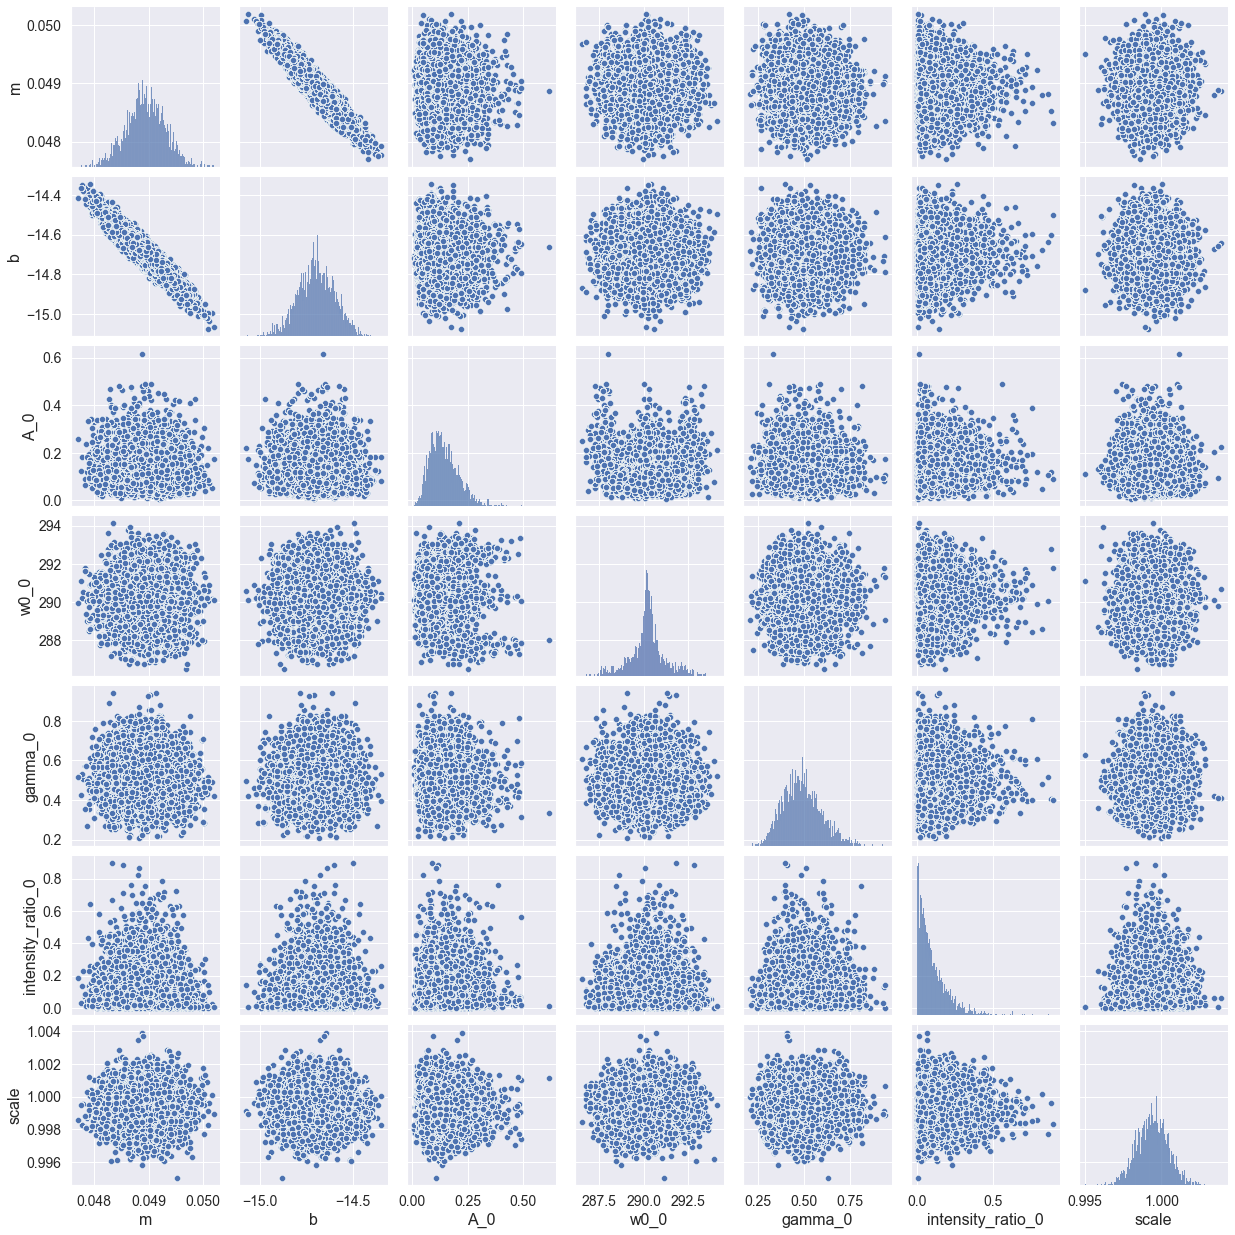

In [33]:
sns.pairplot(posterior.drop('prediction', axis=1))

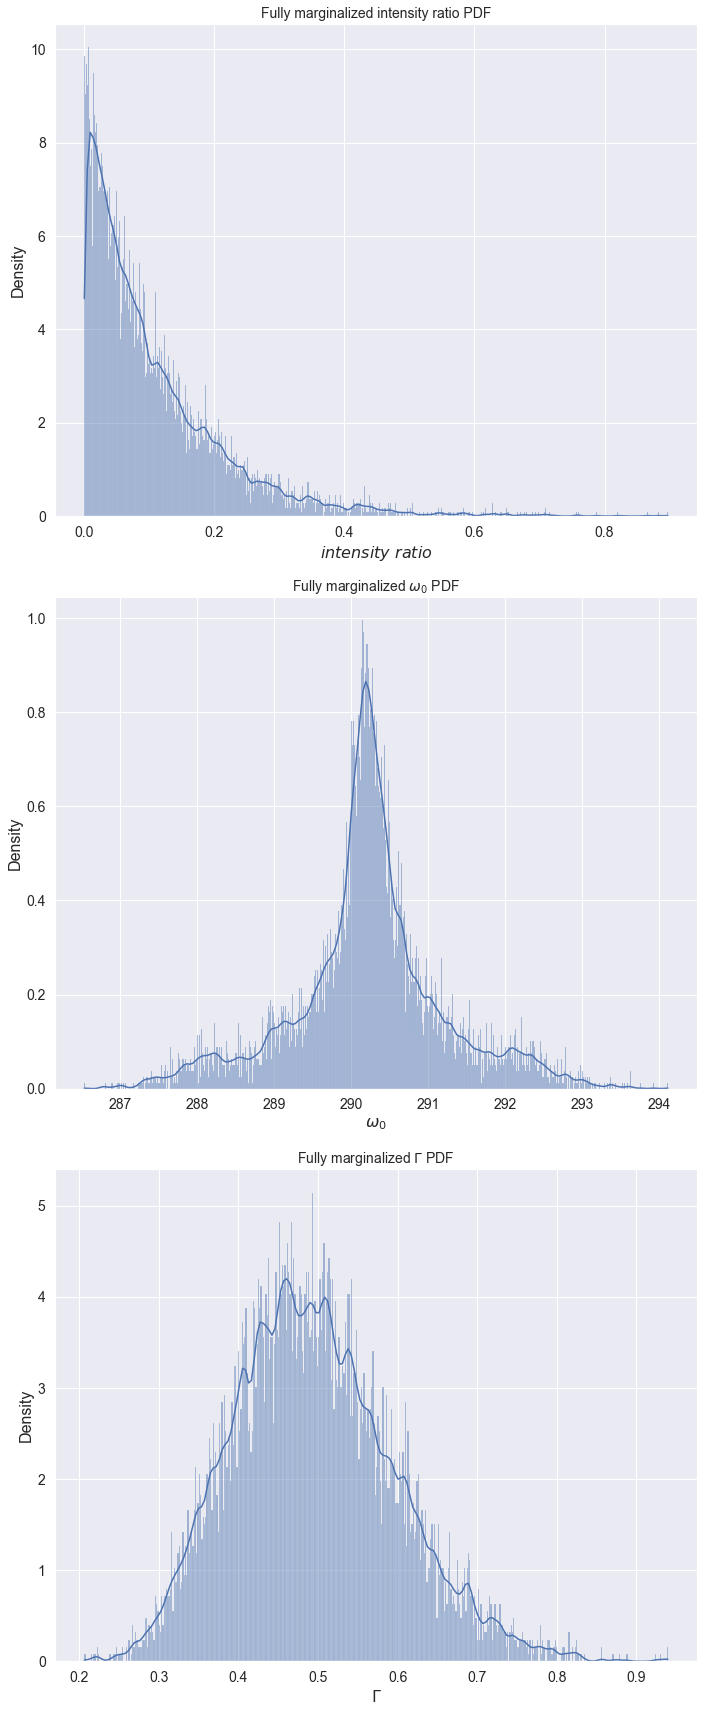

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 24))

marg_intensity_ratio = sns.histplot(posterior.intensity_ratio_0,
                                    fill=True, stat="density",
                                    kde=True,
                                    ax=ax1
                                    )
marg_intensity_ratio.set(xlabel='$intensity \ ratio$',
                         title='Fully marginalized intensity ratio PDF'
                         );


marg_w0 = sns.histplot(posterior.w0_0,
                       fill=True, stat="density",
                       kde=True,
                       ax=ax2
                      )
marg_w0.set(xlabel='$\omega_0$',
            title='Fully marginalized $\omega_0$ PDF'
            );

marg_gamma = sns.histplot(posterior.gamma_0,
                          fill=True, stat="density",
                          kde=True,
                          ax=ax3
                         )
marg_gamma.set(xlabel='$\Gamma$',
               title='Fully marginalized $\Gamma$ PDF'
               );

plt.tight_layout()

In [35]:
summary = az.summary(trace, hdi_prob=.95)[0:6]
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.049,0.000,0.048,0.050,0.000,0.000,4438.0,4447.0,1.0
b,-14.697,0.099,-14.890,-14.504,0.001,0.001,4535.0,4662.0,1.0
A_0,0.143,0.066,0.032,0.274,0.001,0.001,5048.0,3949.0,1.0
w0_0,290.223,0.998,287.960,292.385,0.018,0.013,3494.0,2545.0,1.0
gamma_0,0.495,0.102,0.303,0.694,0.001,0.001,5904.0,4631.0,1.0
intensity_ratio_0,0.107,0.106,0.000,0.315,0.001,0.001,4238.0,2791.0,1.0


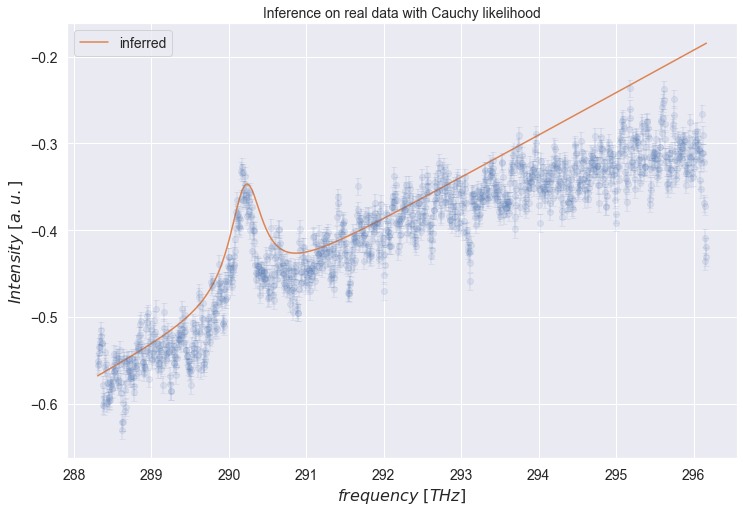

In [36]:
plt.figure(figsize=(12,8))
plt.errorbar(w, I, fmt='o', yerr=sigma_I, capsize=3, alpha=.1)
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('Inference on real data with Cauchy likelihood');

A_inf = summary['mean']['A_0']
w0_inf = summary['mean']['w0_0']
gamma_inf = summary['mean']['gamma_0']
intensity_ratio_inf = summary['mean']['intensity_ratio_0']

m_inf = summary['mean']['m']
b_inf = summary['mean']['b']

w_inf = np.linspace(real_data.w.min(), real_data.w.max(), 250)

prediction_inferred = Prediction([
                                 (A_inf, w0_inf, gamma_inf, intensity_ratio_inf),
                                  ],
                                 m_inf,
                                 b_inf
                        ).prediction(w_inf)

plt.plot(w_inf, prediction_inferred, label='inferred')
plt.legend();